In [1]:
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import igraph as ig

from numpy import sqrt
from gurobipy import GRB
from pyinstrument import Profiler
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline
# matplotlib.use('TkAgg')

In [2]:
## 数据读取与参数设置
def dist(p1, p2):
    return sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def viaShop(p1, p2, p3):
    return dist(p1, p2) + dist(p2, p3)

def Charge_viaShop(p1, p2, p3, p4):
    return dist(p1, p2) + dist(p2, p3) + dist(p3, p4)


# 数据读取
df1 = pd.read_excel('./q1data.xlsx')
pattern = r'\((-?\d+\.\d+), (-?\d+\.\d+)\)'
df1[['x', 'y']] = df1['坐标'].str.extract(pattern)
df1[['x', 'y']] = df1[['x', 'y']].astype(float)
df1['points'] = df1.apply(lambda row: [row['x'], row['y']], axis=1)
df1.drop(columns=['x', 'y', '坐标'], inplace=True)

# 参数设置
M = 1 << 16
droneSpeed = 60
droneMaxPower = 10
droneNumber = 2
userNumber = df1.shape[0]

shop = [[0.5, 0]]
chargeStation = [0, 0]

# 构建耗时矩阵
matSize = 2 * userNumber + 2
distMat = np.full((matSize, matSize), float(M))
for i in range(2 * userNumber + 1):
    for j in range(1, 2 * userNumber + 2):
        if i >= 1:
            userPoint1 = df1.loc[(i - 1) % userNumber, 'points']
        if j >= 1:
            userPoint2 = df1.loc[(j - 1) % userNumber, 'points']
        # 起点到某处
        if 1 <= j <= userNumber:
            if i == 0:
                distMat[i, j] = viaShop(chargeStation, shop[0], userPoint2)
            else:
                distMat[i, j] = viaShop(userPoint1, shop[0], userPoint2) 
        elif userNumber + 1 <= j <= 2 * userNumber:
            if i == 0:
                continue
            else:
                distMat[i, j] = Charge_viaShop(userPoint1, chargeStation, shop[0], userPoint2)
        elif j == 2 * userNumber + 1:
            if i == 0:
                continue
            else:
                distMat[i, j] = dist(userPoint1, chargeStation)

                                

In [3]:
## 第二问线性规划

# 确认分块点集
Sp = [0]
Ep = [matSize - 1]
I1 = list(range(1, userNumber + 1))
I2 = list(range(userNumber + 1, 2 * userNumber + 1))
U = Sp + I1 + I2 + Ep


prob2 = gp.Model('q2无人机调度')

x = prob2.addVars(droneNumber, matSize, matSize, vtype=GRB.BINARY, name='workingPath')
phi = prob2.addVars(droneNumber, matSize, lb=0, ub=10, vtype=GRB.CONTINUOUS, name='remainPower')
u = prob2.addVars(droneNumber, matSize, vtype=GRB.INTEGER, name='order')
d = prob2.addVars(droneNumber, vtype=GRB.CONTINUOUS, name='dis')
dMax = prob2.addVar(vtype=GRB.CONTINUOUS, name='disMax')

## 约束

# 对于每一个无人机
for k in range(droneNumber):
    # 不可能路径约束
    prob2.addConstr(gp.quicksum(x[k, i, j] for i in (Sp + I1 + I2 + Ep) for j in Sp) == 0)
    prob2.addConstr(gp.quicksum(x[k, i, j] for i in Sp for j in (I2 + Ep)) == 0)
    prob2.addConstr(gp.quicksum(x[k, i, j] for i in Ep for j in (I1 + I2 + Ep)) == 0)
    prob2.addConstrs(x[k, i, i] == 0 for i in I1 + I2)

    # 起点终点约束
    prob2.addConstr(gp.quicksum(x[k, 0, j] for j in I1) == 1)
    prob2.addConstr(gp.quicksum(x[k, i, matSize - 1] for i in (I1 + I2)) == 1)
    
    # 连续路径约束
    for i in range(1, matSize - 2):
        prob2.addConstr(gp.quicksum(x[k, i, j] for j in (Sp + I1 + I2 + Ep)) == 
                        gp.quicksum(x[k, j, i] for j in (Sp + I1 + I2 + Ep)))
    
    # MTZ约束
    # 起点
    prob2.addConstr(u[k, 0] == 1)
    # 起点到第一个顾客
    prob2.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                     for i in Sp for j in I1)
    # 顾客到顾客
    prob2.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                     for i in (I1 + I2) for j in (I1 + I2))
    # 顾客到终点
    prob2.addConstrs(u[k, i] - u[k, j] + matSize * x[k, i, j] <= matSize - 1 
                     for i in (I1 + I2) for j in Ep)
    
    # 起始电量
    prob2.addConstr(phi[k, 0] == 10)
    
    # 不充电
    for i in (Sp + I1 + I2):
        for j in I1:
            prob2.addConstr(phi[k, j] <= phi[k, i] - distMat[i, j] + M * (1 - x[k, i, j]))
            prob2.addConstr(phi[k, j] >= phi[k, i] - distMat[i, j] - M * (1 - x[k, i, j]))
    for i in (I1 + I2):
        for j in Ep:
            prob2.addConstr(phi[k, j] <= phi[k, i] - distMat[i, j] + M * (1 - x[k, i, j]))
            prob2.addConstr(phi[k, j] >= phi[k, i] - distMat[i, j] - M * (1 - x[k, i, j]))
    
    # 充电
    for i in (I1 + I2):
        for j in I2:
            prob2.addConstr(phi[k, j] <= 10 - distMat[0, j % userNumber] + M * (1 - x[k, i, j]))
            prob2.addConstr(phi[k, j] >= 10 - distMat[0, j % userNumber] - M * (1 - x[k, i, j]))
    
    # 每一个无人机的耗时
    prob2.addConstr(d[k] == gp.quicksum(x[k, i, j] * distMat[i, j] for i in U for j in U))

# 更改顾客服务约束
for i in range(1, userNumber + 1):
    pos1 = i
    pos2 = i + userNumber
    prob2.addConstr(gp.quicksum(x[k, pos1, j] + x[k, pos2, j] 
                                for j in (Sp + I1 + I2 + Ep) for k in range(droneNumber)) == 1)

# 最大耗时约束
prob2.addConstrs(dMax >= d[k] for k in range(droneNumber))

## 目标函数
prob2.setObjective(dMax)
prob2.write('./q2model.lp')

prob2.Params.NoRelHeurTime = 15
prob2.Params.TimeLimit = 30
prob2.Params.MIPFocus = 3


Set parameter NoRelHeurTime to value 15
Set parameter TimeLimit to value 30
Set parameter MIPFocus to value 3


In [7]:
prob2.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2686 rows, 1059 columns and 10442 nonzeros
Model fingerprint: 0x4c3ba33c
Variable types: 47 continuous, 1012 integer (968 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 688 rows and 232 columns
Presolve time: 0.11s
Presolved: 1998 rows, 827 columns, 12936 nonzeros
Variable types: 43 continuous, 784 integer (744 binary)
Starting NoRel heuristic
Found phase-1 solution: relaxation 12.0308
Found phase-1 solution: relaxation 10.0308
Found phase-1 solution: relaxation 5.03079
Found heuristic solution: objective 18.6755801
Transition to phase 2
Found heuristic solution: objective 18.4219928
Found heuristic solution: obj

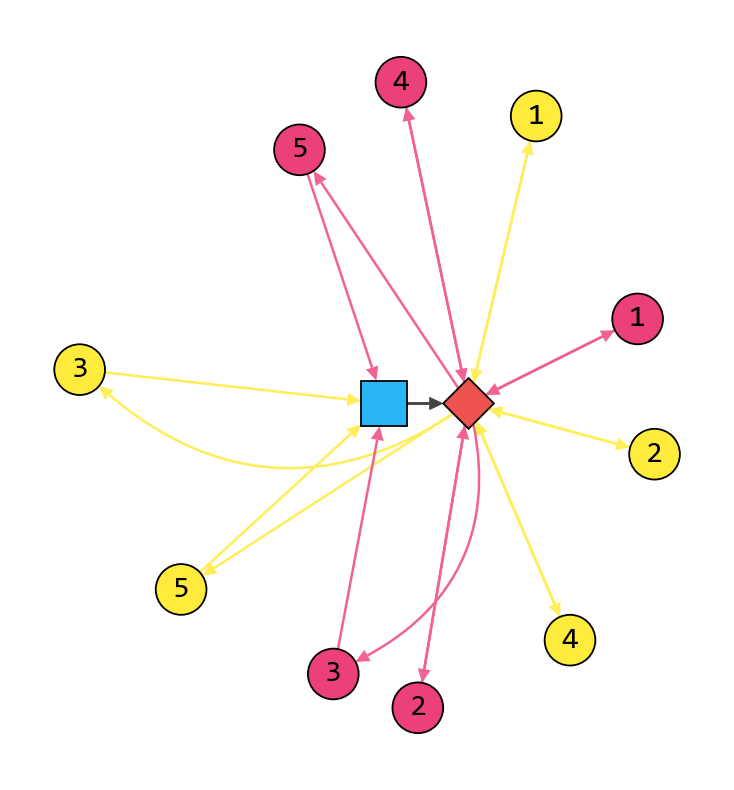

In [26]:
def find_cycle_points(A, start_point):
    # 记录已访问的节点
    visited = set()
    # 存储结果的列表
    cycle_points = []

    # 深度优先搜索
    def dfs(node):
        visited.add(node)
        cycle_points.append(node)

        for next_node in range(len(A[node])):
            if next_node not in visited and A[node][next_node] > 0.5:
                dfs(next_node)

    # 从起点开始搜索
    dfs(start_point)

    return cycle_points

def draw_graph(df, charge_station, shops, paths):
    # 两架无人机的轨迹颜色
    edge_color = ['#FFEE58','#F06292']
    node_color = ['#FFEB3B','#EC407A']
    
    g = ig.Graph(directed=True)
    
    user_number = df.shape[0]
    shop_number = len(shops)
    total_nodes = 1 + shop_number + user_number
    # 添加点顺序：充电站--商店--顾客
    g.add_vertices(total_nodes)
    g.vs["x"] = ([charge_station[0]] + 
                 [shops[i][0] for i in range(len(shops))]+
                 [df1.points[i][0] for i in range(len(df1.points))])
    g.vs["y"] = ([charge_station[1]] + 
                 [shops[i][1] for i in range(len(shops))]+
                 [df1.points[i][1] for i in range(len(df1.points))])
    g.vs["shape"] = ["rectangle", "diamond"] + ["circle" for _ in range(user_number)]
    g.vs["color"] = ["#29B6F6", "#EF5350"] + ["#FFEE58" for _ in range(user_number)]
    g.vs["size"] = [0.27, 0.3] + [0.3 for _ in range(user_number)]
    
    # 建立path点到图中点的映射字典
    point_dict = {}
    for i in range(1, 2 * user_number + 1):
        point_dict[i] = ((i - 1) % user_number) + 1 + shop_number
    
    # 遍历path添加边
    for k, path in enumerate(paths):
        for i in range(len(path) - 1):
            if i == 0:
                start_point = 0
                mid_point = 1
                end_point = point_dict[path[i + 1]]
                # 添加两条边
                g.add_edge(start_point, mid_point, curved=0.0)
                # g.add_edge(mid_point, end_point)
                # 添加访问编号
                g.vs[end_point]["label"] = i + 1
                g.vs[end_point]["label_size"] = 22
                g.vs[end_point]["color"] = node_color[k]
                continue
            elif i == len(path) - 2:
                start_point = point_dict[path[i]]
                mid_point = 1
                end_point = 0
                # 添加一条边
                g.add_edge(mid_point, start_point, curved=0.0, color=edge_color[k])
                g.add_edge(start_point, end_point, curved=0.0, color=edge_color[k])
                continue
                
            # 中间的情况
            if 1 <= path[i + 1] <= user_number:
                # 不充电
                start_point = point_dict[path[i]]
                mid_point = 1
                end_point = point_dict[path[i + 1]]
                g.add_edge(mid_point, start_point, curved=0, color=edge_color[k])
                g.add_edge(start_point, mid_point, curved=0, color=edge_color[k])
                g.vs[end_point]["label"] = i + 1
                g.vs[end_point]["label_size"] = 22
                g.vs[end_point]["color"] = node_color[k]
            elif user_number + 1 <= path[i + 1] <= 2 * user_number + 1:
                start_point = point_dict[path[i]]
                mid_point1 = 0
                mid_point2 = 1
                end_point = point_dict[path[i + 1]]
                g.add_edge(mid_point2, start_point, curved=0.5, color=edge_color[k])
                g.add_edge(start_point, mid_point1, curved=0, color=edge_color[k])
                g.vs[end_point]["label"] = i + 1
                g.vs[end_point]["label_size"] = 22
                g.vs[end_point]["color"] = node_color[k]
    return g

xMat = np.zeros((droneNumber, matSize, matSize))
Paths = []
for k in range(droneNumber):
    for i in range(matSize):
        for j in range(matSize):
            xMat[k, i, j] = x[k, i, j].x
        
    Paths.append(find_cycle_points(xMat[k], 0))

g = draw_graph(df1, chargeStation, shop, Paths)

layout = g.layout_auto()
fig, ax = plt.subplots(figsize=(40, 10))
ig.plot(g, target=ax, layout=layout, edge_width=1.8, vertex_frame_width=1.3, edge_arrow_size=0.006)
plt.savefig('q2工作路径.svg', format="svg", bbox_inches='tight',pad_inches=-0.4)

In [7]:
## 生成问题二收敛结果

# 生成问题一结果报告
import time
def mycallback(model, where):
    if where == GRB.Callback.MIP:
        # MIP solution callback
        currentTime = time.time()
        solName = int((currentTime - model._startTime) / model._interval) * model._interval
        
        # Statistics
        obj = model.cbGet(GRB.Callback.MIP_OBJBST)

        # Export statistics
        msg = str(currentTime-model._startTime) + " " + str(obj) + "\n"
        model._reportFile.write(msg)
        model._reportFile.flush()
        
model = gp.read('q2model.lp')
# 求解参数
model.Params.NoRelHeurTime = 5
model.Params.TimeLimit = 5

reportFile = open('q2report.txt', 'w')

model._startTime = time.time()
model._reportFile = reportFile
model._interval = 1  #每隔一段时间输出当前可行解，单位秒

model.optimize(mycallback)




Read LP format model from file q2model.lp
Reading time = 0.01 seconds
: 2686 rows, 1059 columns, 10442 nonzeros
Set parameter NoRelHeurTime to value 5
Set parameter TimeLimit to value 5
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2686 rows, 1059 columns and 10442 nonzeros
Model fingerprint: 0xcc01bcc2
Variable types: 47 continuous, 1012 integer (968 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 688 rows and 232 columns
Presolve time: 0.04s
Presolved: 1998 rows, 827 columns, 8576 nonzeros
Variable types: 43 continuous, 784 integer (744 binary)
Starting NoRel heuristic
Found phase-1 solution: relaxation 21.7064
Found phase-1 solution: relaxation 18.3133
Fou

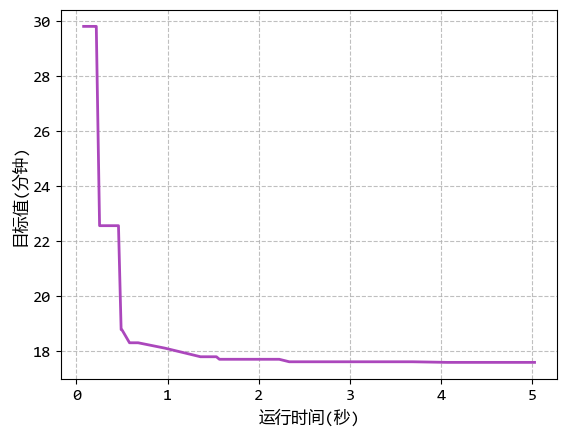

In [8]:
# 绘制收敛曲线
def read_report(filepath,save_name):
    # 存储数据的列表
    timestamps = []
    obj_values = []

    # 读取txt文件
    with open(filepath, 'r') as file:
        for line in file:
            # 分割每行的数据
            parts = line.split(' ')
            timestamp = float(parts[0].strip())
            obj_value = float(parts[1].strip())
            timestamps.append(timestamp)
            obj_values.append(obj_value)
    # 绘制图形
    plt.plot(timestamps, obj_values, color='#AB47BC', linestyle='-', linewidth=2)
    plt.xlabel('运行时间(秒)')
    plt.ylabel('目标值(分钟)')
    plt.grid(ls='--',alpha=0.8)
    plt.savefig(save_name, format='svg')

read_report('./q2report.txt','q2收敛曲线.svg')